In [ ]:
from IPython.display import clear_output

In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [ ]:
import random

import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
to_tensor = transforms.ToTensor()

class GrayScaleToColorTransform:

    def __call__(self, img):
        return to_tensor(img.convert('L')), to_tensor(img)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    GrayScaleToColorTransform()
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [ ]:
(gs_img, rgb_img), _ = image_dataset[0]  # _ is the image class which we don't need for this assignment

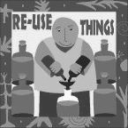

In [ ]:
transforms.functional.to_pil_image(gs_img)

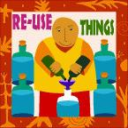

In [ ]:
transforms.functional.to_pil_image(rgb_img)

In [ ]:
print(len(image_dataset))

9144


# Tasks:

1. Build a custo [AutoEncoder] NN model. The input to the model is the Gray Scale Image and it's output should be colored image.
2. Split the data into training and validation splits (80%, 20%). Train the model on training data.
3. After training, show final loss value as well as draw a plot to show how loss dropped during training (both train and val loss).
4. Manually show the model's performance. Pick 3 random grayscale image, and RGB img pairs from the **val dataset** and for each of the grayscale image, show the grayscale img, the RGB image, and the model output image.